## Import des données

In [1]:
import pandas as pd
import geopandas
import geoplot
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn')

In [2]:
df = pd.read_csv("./data/R201801.CSV", 
                 engine='python', 
                 sep=";", 
                 nrows=500000, 
                 usecols=["dep_mon", "dpt", "exe_spe"])


## Clean des données

In [3]:
df["dep_mon"] = df["dep_mon"].str.replace(".","")
df["dep_mon"] = df["dep_mon"].str.replace(",",".")

In [4]:
df["dep_mon"] = df["dep_mon"].astype("float64")

## Calcul des consultation avec dépensement et de toutes les consultations par régions

In [5]:
df_dep_mon=df[df["dep_mon"] != 0]

In [6]:
df_dep = df_dep_mon.groupby("dpt").count().rename(columns={"dep_mon":"count_dep"})["count_dep"]
df_all = df.groupby("dpt").count().rename(columns={"dep_mon":"count_tot"})

In [7]:
df_join = df_all.join(df_dep).drop(columns=["exe_spe"])

## Calcul du pourcentage de consulation ayant un dépassement par région

In [8]:
df_join["percent"]=df_join["count_dep"] / df_join["count_tot"] *100

In [9]:
df_join.sort_values("percent", ascending=False).head(5)

,count_tot,count_dep,percent
dpt,,,
92,11822,4665,39.460328
75,15814,6074,38.409005
78,9104,3422,37.587873
69,8889,3116,35.054562
77,7905,2733,34.573055


## Import du DataFrame des médecins

In [10]:
df_medecin = pd.read_excel("./data/rpps-medecins.xls",
                          header=5,
                          usecols=["SPECIALITE",
                                   "Ensemble des spécialités d'exercice",
                                   "Gériatrie",
                                  "Pédiatrie"])
df_medecin = df_medecin.rename(columns={"SPECIALITE":"departement","Ensemble des spécialités d'exercice":"densite_medecin"})
df_medecin = df_medecin[df_medecin["departement"].str.contains("^[0-9]")]

In [11]:
df_medecin["dep_code"] = df_medecin["departement"].str.split("-").str[0].str.strip()
df_medecin = df_medecin.set_index("dep_code")

In [12]:
df_densité = df_medecin[["departement", "densite_medecin"]]
df_densité.sort_values("densite_medecin", ascending=False ).head(5)

,departement,densite_medecin
dep_code,,
75,75 - Paris,858.3
06,06 - Alpes-Maritimes,461.3
69,69 - Rhône,447.6
13,13 - Bouches-du-Rhône,444.0
05,05 - Hautes-Alpes,440.6


## Join des deux data frames

In [13]:
df_result = df_join.join(df_densité, how="right")

In [14]:
df_result.sort_values("percent", ascending=False).head(5)

,count_tot,count_dep,percent,departement,densite_medecin
dep_code,,,,,
92,11822,4665,39.460328,92 - Hauts-de-Seine,399.2
75,15814,6074,38.409005,75 - Paris,858.3
78,9104,3422,37.587873,78 - Yvelines,286.8
69,8889,3116,35.054562,69 - Rhône,447.6
77,7905,2733,34.573055,77 - Seine-et-Marne,214.0


## Représentation Graphique

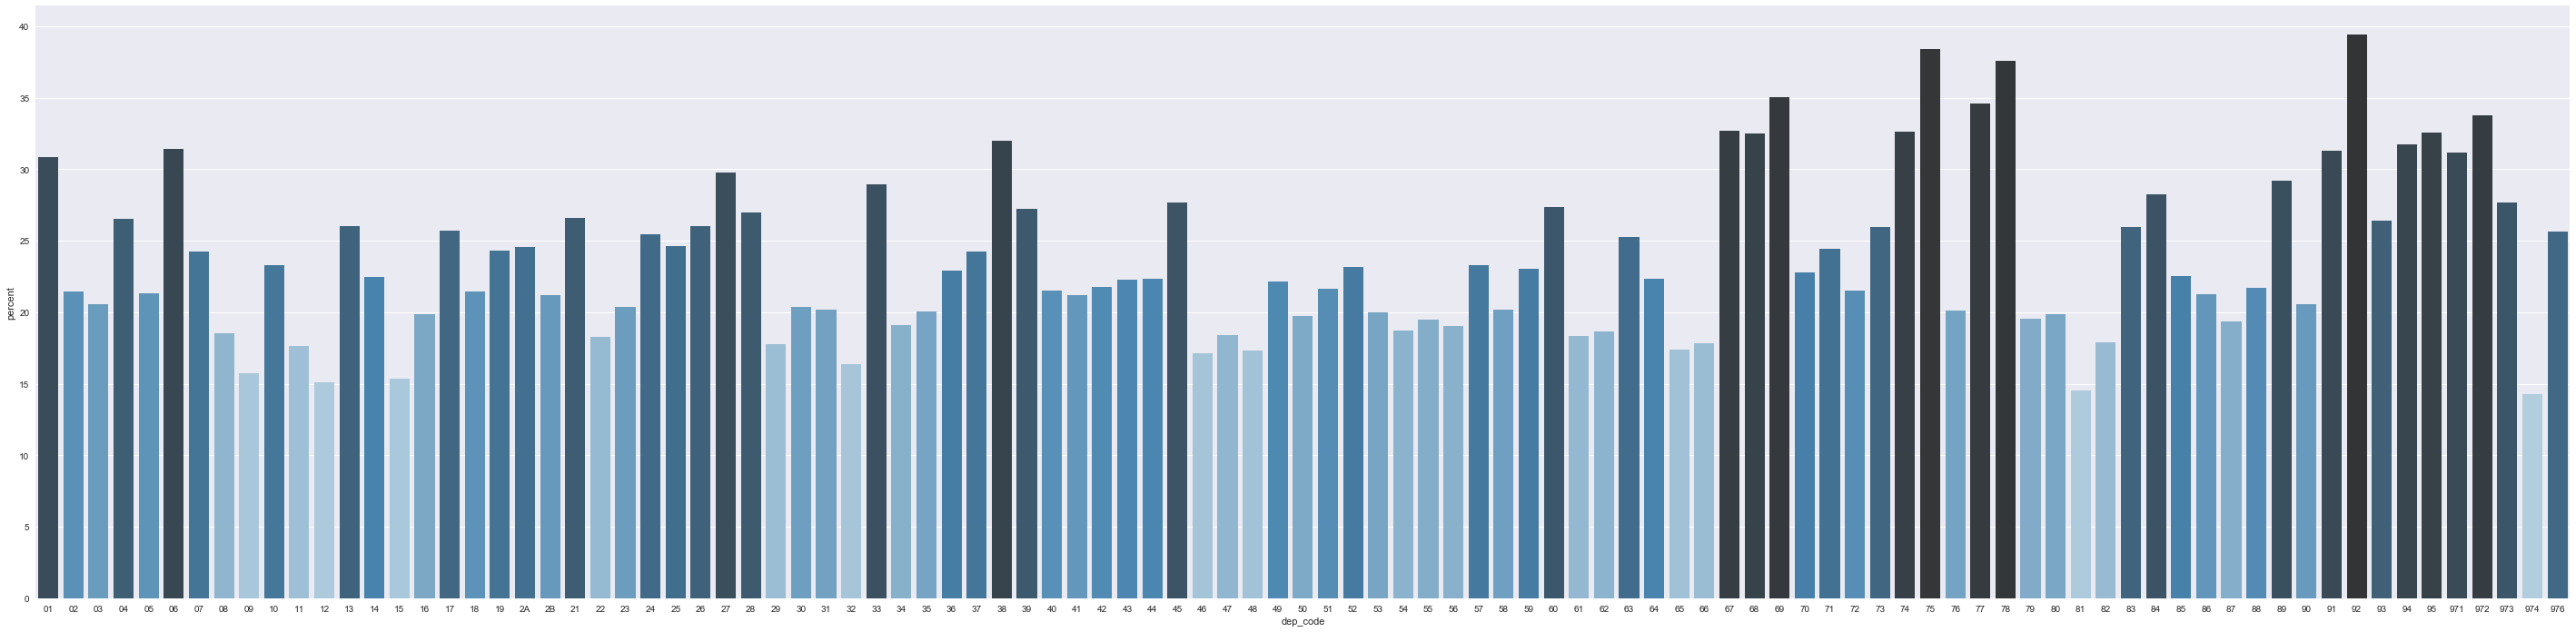

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.figure(figsize=(50, 12))
pal = sns.color_palette("Blues_d", len(df_result["percent"]))
rank = df_result["percent"].argsort().argsort() 
g1 = sns.barplot(x=df_result.index, y="percent",\
                data=df_result,
                palette=np.array(pal[::-1])[rank])
plt.show()

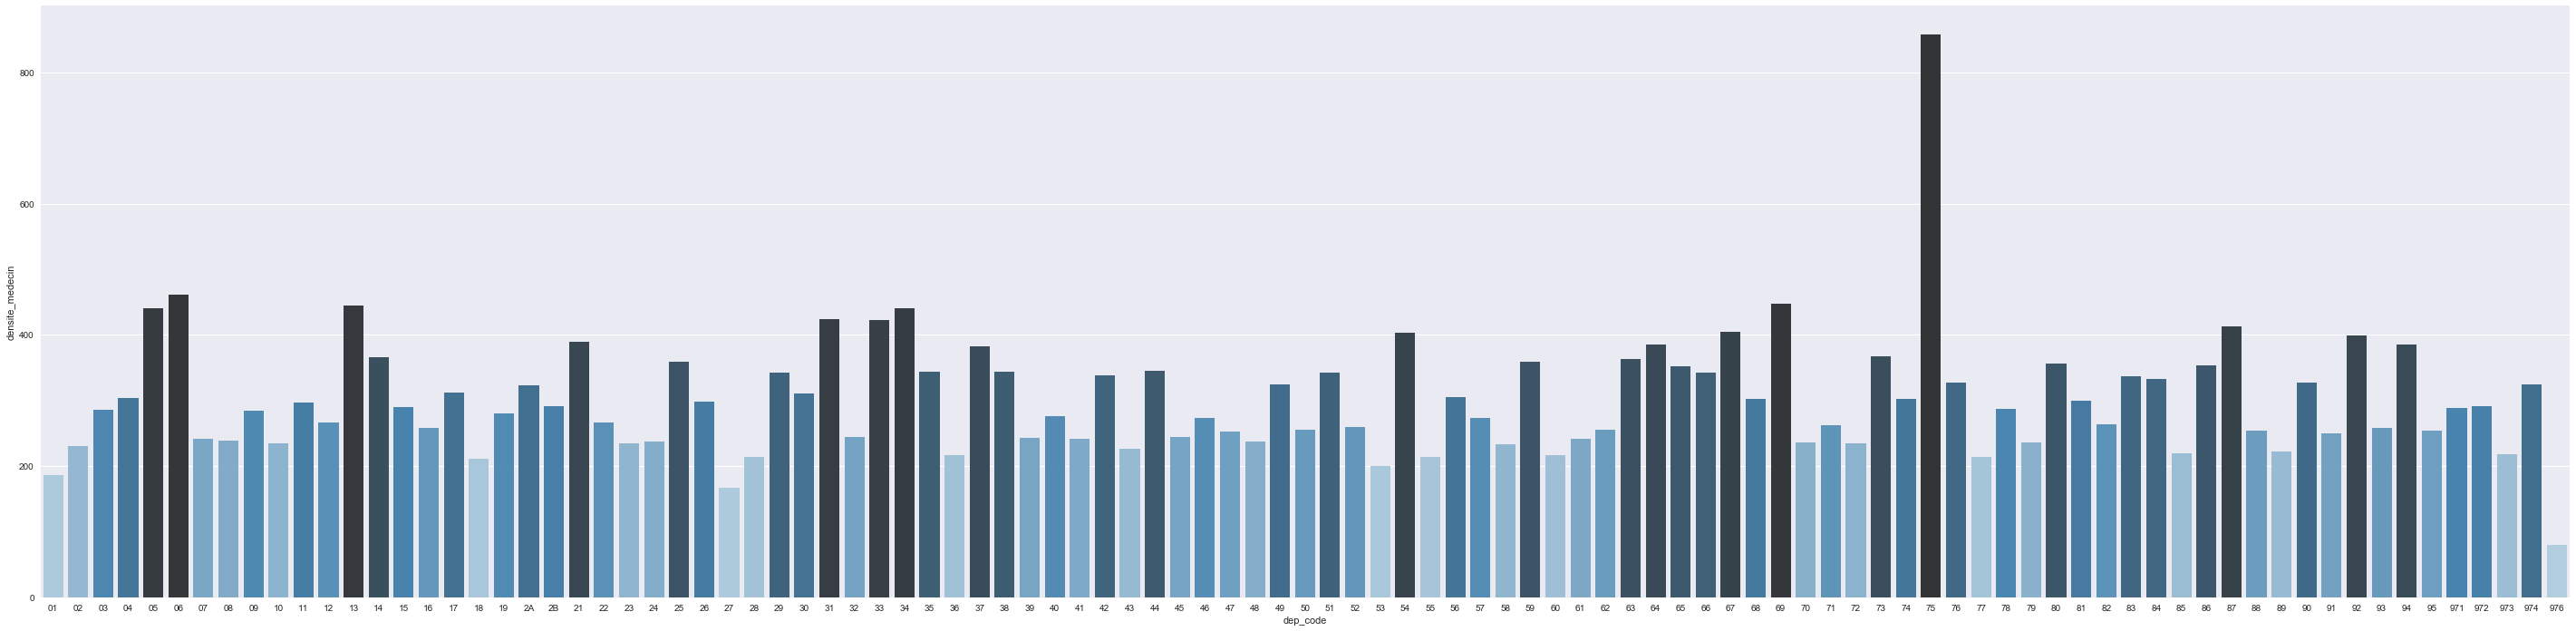

In [16]:
plt.figure(figsize=(50, 12))
df_toPlot = df_result.fillna(0)
pal2 = sns.color_palette("Blues_d", len(df_toPlot["densite_medecin"]))
rank2 = df_toPlot["densite_medecin"].argsort().argsort()
g2 = sns.barplot(x=df_toPlot.index, y="densite_medecin", \
                data=df_toPlot,
                palette=np.array(pal2[::-1])[rank2])
plt.show()

In [17]:
france = geopandas.read_file("./data/carte/departements-20170102.shp")

In [18]:
france = france.join(df_result, on="code_insee")

In [19]:
france = france.dropna()

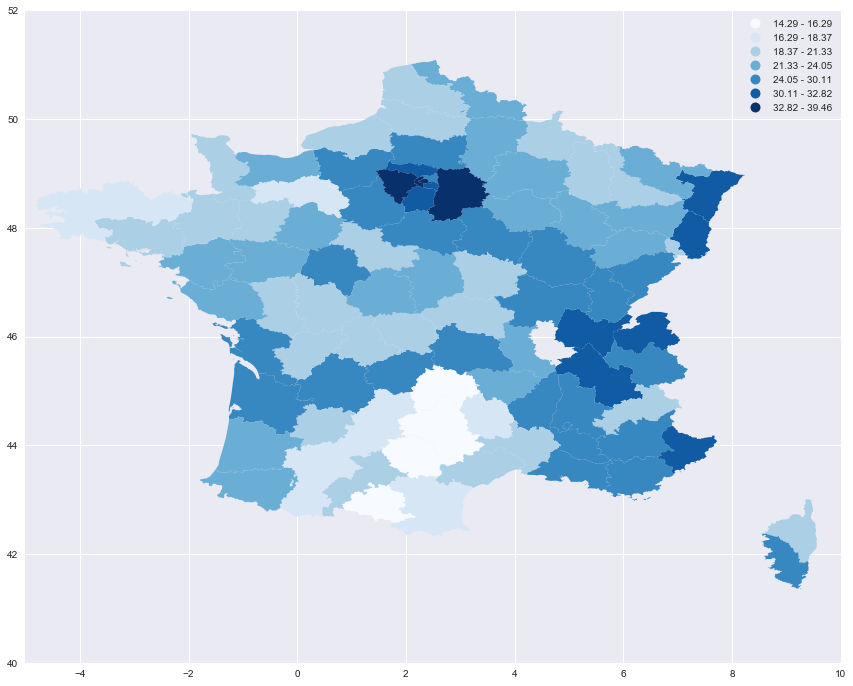

In [26]:
plt.figure(figsize=(50, 12))
axes = plt.gca()
axes.set_xlim(-5, 10)
axes.set_ylim(40, 52)
france.plot(column='percent', 
            ax=axes, 
            legend=True, 
            cmap='Blues',
            scheme='percentiles',
            classification_kwds={'pct': [5, 15, 40, 60, 85, 95, 100]})

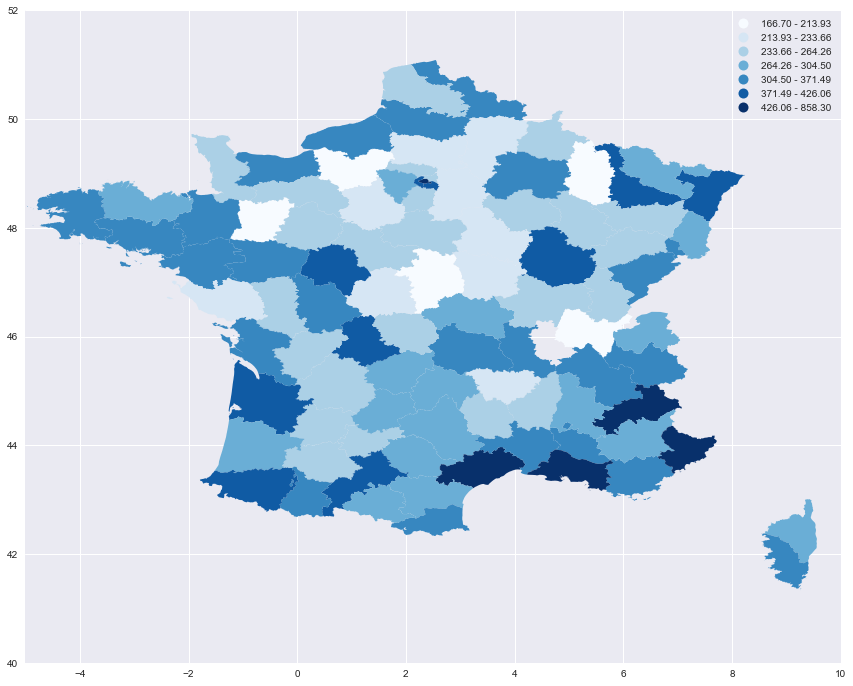

In [27]:
plt.figure(figsize=(50, 12))
axes = plt.gca()
axes.set_xlim(-5, 10)
axes.set_ylim(40, 52)
france.plot(column='densite_medecin', 
            ax=axes, 
            legend=True, 
            cmap='Blues',
            scheme='percentiles',
            classification_kwds={'pct': [5, 15, 40, 60, 85, 95, 100]})

## Interprétation

Au vu des données les zones de dépassement d'honoraires ne sont pas liée à la densité de medecin. 

Néanmoins l'étude de données des dépassements n'a été faite que sur une petite partie des données du mois de janvier seulement. Il n'est donc pas representatif de la tendence réelle.

## Etude des spécialité en fonction de l'âge

In [22]:
df_age = pd.read_excel("./data/estim-pop-dep-sexe-gca-1975-2019.xls", 
                       "2019",
                      header=4,
                      usecols=[0,1,2,3,4,5,6,7])
df_age= df_age.rename(columns={"Unnamed: 0":"code_dep",
                      "Unnamed: 1":"departement",
                      "0 à 19 ans":"0_19",
                      "20 à 39 ans":"20_39",
                      "40 à 59 ans":"40_59",
                      "60 à 74 ans":"60_74",
                      "75 ans et plus":"75_",})
df_age = df_age.dropna()


In [23]:
data = df_age.join(df_medecin, on="code_dep", rsuffix="r")

In [24]:
data["0_19_%"] = data["0_19"] / data["Total"] *100
data["75_%"] = data["75_"] /  data["Total"] *100
data["Geriatrie%"] = data["Gériatrie"] / data["densite_medecin"] *100
data["Pediatrie%"] = data["Pédiatrie"] / data["densite_medecin"] *100

In [25]:
data[["0_19_%","Pediatrie%","75_%","Geriatrie%"]]

,0_19_%,Pediatrie%,75_%,Geriatrie%
0,25.657500,12.977921,8.070364,1.615509
1,24.892238,19.583152,9.115254,1.780287
2,20.304745,8.698702,13.303409,1.227639
3,20.918015,11.443604,12.660205,0.822098
4,21.524290,13.368134,11.559837,0.317749
...,...,...,...,...
97,25.264434,22.691110,8.252853,0.622622
98,22.464142,25.008588,9.979855,0.549639
99,41.323712,17.768595,1.776813,0.183655
100,30.738391,22.814039,4.913526,0.400246
